Exploring tiff data, that is segmentation maps of the sliced battery.

In [3]:
# Libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

folder_path = 'data/raw/seg_data'

In [2]:
config = {
    "num_images": 169,
    "num_attribs": 7,
    "titles": ['Min Value',
               'Max Value',
               'Average Value',
               'Variation', 
               'Absolute Value Sum',
               'Non-data Region',
               'Entropy'],
    "img_size": (170, 170)
}

In [57]:
# Utility functions
def normalize_img(img, eps=1e-10):
    img = img - np.min(img)
    img = img / (np.max(img) + eps)
    return img

def clamp_img(img, low=1.0, up=6.0):
    img[img < low] = low
    img[img > up] = up
    return img

In [69]:
def load_and_check_image(image_path, verbose=False):
    img = Image.open(image_path)
    img_array = np.array(img) # shape: (170, 170)
    color_mode = "RGB" if img.mode in ("RGB", "RGBA") else "Grayscale"
    
    if verbose:
        print(f'Inspecting image {image_path}')
        print("Image shape:", img_array.shape)
        print(f"Color mode: {img.mode} ({color_mode})")
        print("Data type:", img_array.dtype)
        print(f"Max: {img_array.max()}, min: {img_array.min()}")

    return img_array

def show_image_hist(folder_path, img_name):
    image_path = f'{folder_path}/{img_name}.tif'
    img = load_and_check_image(image_path)

    _, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(img, cmap='gray')
    axs[0].axis('off')  # Hide the axis
    axs[0].set_title(f'{img_name}')

    axs[1].hist(img.flatten(), bins=50, range=(0,1500), log=True)
    axs[1].set_title('Histogram')

    plt.tight_layout()
    plt.show()

In [70]:
_ = load_and_check_image(folder_path+'/tif0031.tif', verbose=True)

Inspecting image data/raw/seg_data/tif0031.tif
Image shape: (170, 170)
Color mode: I;16 (Grayscale)
Data type: uint16
Max: 186, min: 0


Interestingly, the images seem to have ascending intensity values.

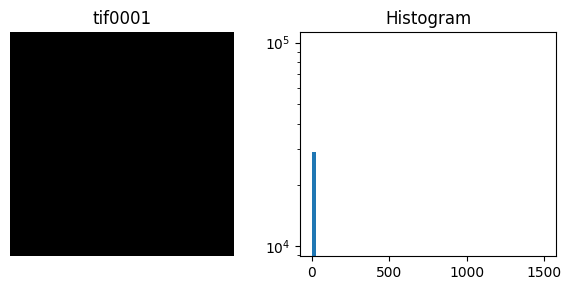

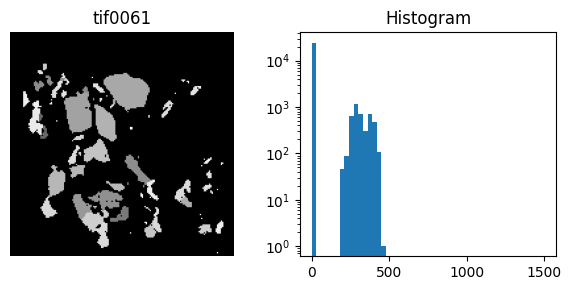

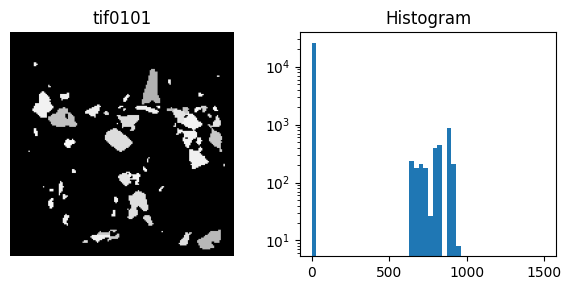

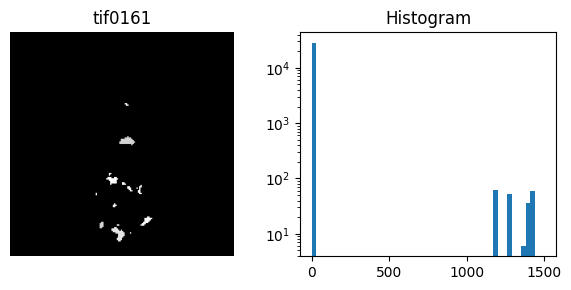

In [62]:
show_image_hist(folder_path, 'tif0001')
show_image_hist(folder_path, 'tif0061')
show_image_hist(folder_path, 'tif0101')
show_image_hist(folder_path, 'tif0161')

Raw images have color mode `I;16`, meaning they are in 16-bit grayscale integer mode. 

In [34]:
def load_tif_images(folder_path):
    images = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".tif"):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)#.convert("L")
            img_array = np.array(img)
            images.append(img_array)

    images_array = np.stack(images, axis=0)
    return images_array

images = load_tif_images(folder_path)
print("Stacked image shape:", images.shape)

Stacked image shape: (169, 170, 170)


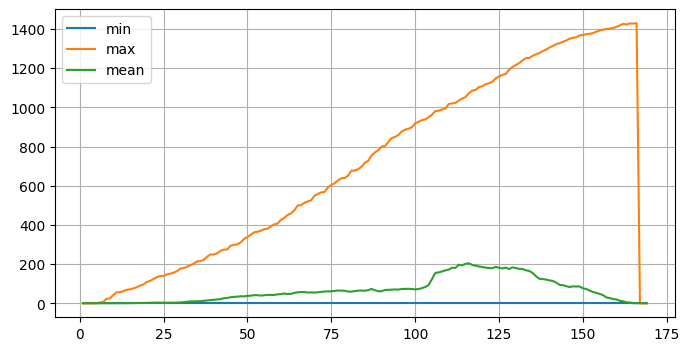

In [35]:
num_images = images.shape[0]
x_values = np.arange(1, num_images+1)
min_values = []
max_values = []
mean_values = []

for i in range(num_images):
    min_values.append(np.min(images[i]))
    max_values.append(np.max(images[i]))
    mean_values.append(np.mean(images[i]))

plt.figure(figsize=[8, 4])
plt.plot(x_values, min_values, label='min')
plt.plot(x_values, max_values, label='max')
plt.plot(x_values, mean_values, label='mean')
plt.legend()
plt.grid()
plt.show()

Normalized raw images (0-1)

In [64]:
num_subset_images = images.shape[0]
img_height, img_width = config["img_size"]
norm_images = np.zeros((num_subset_images, img_height, img_width))

for i in tqdm(range(num_subset_images)):
    cloned_image = images[i].copy()
    norm_images[i] = normalize_img(cloned_image)

print(f"Normalized images with shape {norm_images.shape}, max: {norm_images.max()}, min: {norm_images.min()}")

100%|██████████| 169/169 [00:00<00:00, 5474.37it/s]

Normalized images with shape (169, 170, 170), max: 0.99999999999993, min: 0.0


Save normalized stack of images as npy file.

In [27]:
final_images = norm_images
np.save("output/volume_tiff.npy", final_images)

Save slices as separated jpg files.

In [65]:
output_directory = 'data/denoised/tiff'  # Change this to your desired directory

for i in range(images.shape[0]):
    img = (images[i] * 255).astype(np.uint8)
    pil_image = Image.fromarray(img)
    filename = os.path.join(output_directory, f'image_{i:03d}.jpg')  # e.g., image_000.jpg, image_001.jpg
    pil_image.save(filename)

print(f"Images saved to {output_directory}")

Images saved to data/denoised/tiff
